In [9]:
%load_ext autoreload
%autoreload 2
from fast_rep.rfd_tools  import load_RFD,find_ori_position,smooth,convert_RFD_delta_MRT
from pylab import *
import jax
from fast_rep.read_data import load_muli_from_bedGraph

jax.config.update('jax_enable_x64', True)
jax.config.update("jax_debug_nans", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
RFD["chrI"]

{'chrom': 'chrI',
 'start': array([     0,    100,    200, ..., 248800, 248900, 249000]),
 'end': array([   100,    200,    300, ..., 248900, 249000, 249100]),
 'signals': {'RFD': array([0., 0., 0., ..., 0., 0., 0.]),
  'std_RFD': array([0.35355339, 0.35355339, 0.35355339, ..., 0.35355339, 0.35355339,
         0.35355339]),
  'smth_RFD': array([0., 0., 0., ..., 0., 0., 0.])}}

In [42]:
0.2 / 15**0.5

0.051639777949432225

In [39]:
RFD, _, meta = load_muli_from_bedGraph(bedgraph_file,
                                                    None,
                                                    column_specs=["RFD","std_RFD","smth_RFD"])
noise = np.concatenate([RFD[k]["signals"]["std_RFD"] for k in RFD.keys()])
print(np.mean(noise))

0.04908519642071336


dict_keys(['chrI:0-249100'])


Text(0, 0.5, 'inc RFD/ kb')

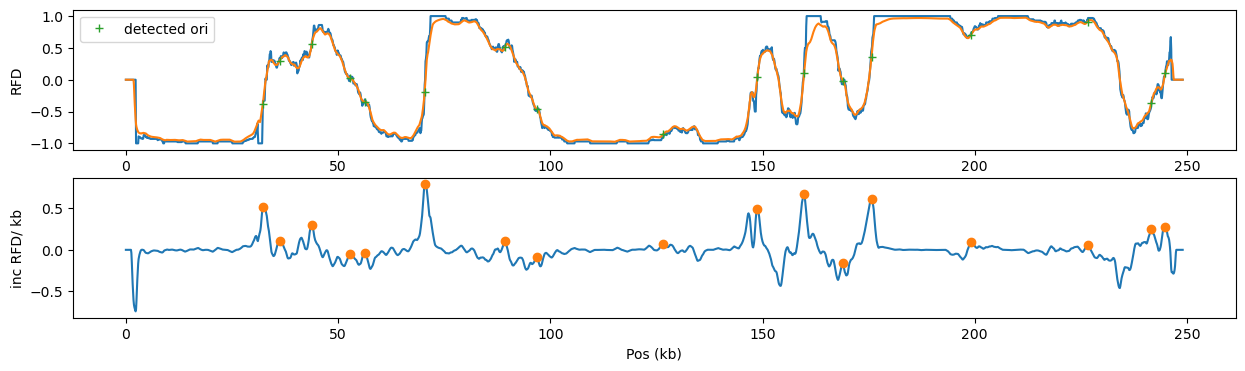

In [10]:
#data = "/home/jarbona/alignExp/notebook/invert_conf/data/NFS/NFS_BTmulti_"
#
#RFD, mean_RFD, Cov_RFD, std_RFD,positif,negatif = load_RFD(root=data, minimum_obs=1)
#
#_,smth_RFD,_,_,_,_ =  load_RFD(root=data,minimum_obs=5,smv=11)
regions_str="chrI"
bedgraph_file="../../data/from_nfs_smv11.bed"
RFD, _, meta = load_muli_from_bedGraph(bedgraph_file,
                                                    regions_str,
                                                    column_specs=["RFD","std_RFD","smth_RFD"])

print(RFD.keys())
key="chrI:0-249100"
rfd = RFD[key]["signals"]["RFD"]
std_RFD = RFD[key]["signals"]["std_RFD"]


smth_RFD = RFD[key]["signals"]["smth_RFD"]

from fast_rep.rfd_tools import find_peaks


resolution = 100
min_dist_ori=3_000   # in bp
pos = np.arange(len(rfd))*resolution

#Detect origin
xis,delta_v,vals=find_ori_position({"rfd":smth_RFD,"positions":pos},min_dist_ori=min_dist_ori,min_rfd_increase_by_kb=0.1) 

f,ax  = subplots(2,1,figsize=(15,4))
ax[0].plot(pos/1000,rfd)
ax[0].plot(pos/1000,smth_RFD)
ax[0].plot(xis/1000,smth_RFD[xis//resolution],"+",label="detected ori")
ax[0].legend()
ax[0].set_xlabel("Pos (kb)")
ax[0].set_ylabel("RFD")


ax[1].plot(pos/1000,delta_v)
ax[1].plot(xis/1000,delta_v[xis//resolution],"o")
ax[1].set_xlabel("Pos (kb)")
ax[1].set_ylabel("inc RFD/ kb")

In [11]:
from fast_rep.math_mod.compute_rfd import compute_derivatives


delta=15
fork_speed=2500
measurement_type = "RFD"

ps,data = convert_RFD_delta_MRT(pos,rfd,speed=fork_speed,resolution=resolution,delta=delta,measurement_type=measurement_type)


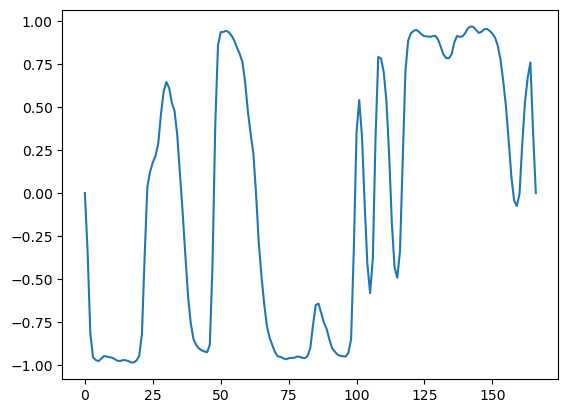

In [222]:
plot(data)

# Generate synthetic data by fitting expereminetal ones

In [17]:
from fast_rep.bayesian_optim import fit_at_pos_using_map_as_starting_point
import jax
import numpy as np
jax.config.update('jax_enable_x64', True)
jax.config.update("jax_debug_nans", True)

import jax.numpy as  jnp
n_ori=len(xis)
S = 20.
initial_lambda = jnp.array([1/(S/2)] * n_ori)
init_qis = None # jnp.array([0.9]  * n_ori)
init_extra_t = jnp.array([4/S]  * n_ori)
fork_speed=2500
r_std = smooth(std_RFD,delta)[::delta]
#r_std = std_RFD[chro][::delta]
#r_std=1

from time import time
t0=time()
model="Weibull"
#r = optim(pos_to_compute=ps,xis=xis,prior_on_lambda=initial_lambda,prior_on_extra_t=init_extra_t,
#          prior_on_qis=init_qis,fork_speed=fork_speed,
#          data=data,S_phase_duration=S,sigma=r_std,measurement_type=measurement_type,model=model,only_optim=True)
r0 = fit_at_pos_using_map_as_starting_point(pos_to_compute=ps,xis=xis,prior_on_lambda=initial_lambda,prior_on_extra_t=init_extra_t,
          prior_on_qis=init_qis,fork_speed=fork_speed,
          data=data,S_phase_duration=S,sigma=r_std,measurement_type=measurement_type,model=model,only_optim=False)

use_qi False
use_extrat True


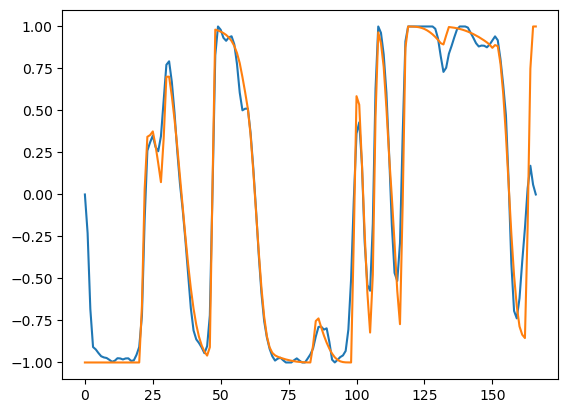

In [14]:
from fast_rep.bayesian_formulation import compute_theo
params = {"kis":initial_lambda,"extra_t":init_extra_t}
params=r0["params"]
#measurement_type="deltaMRT"
plot(data)
plot(r0["theo"])

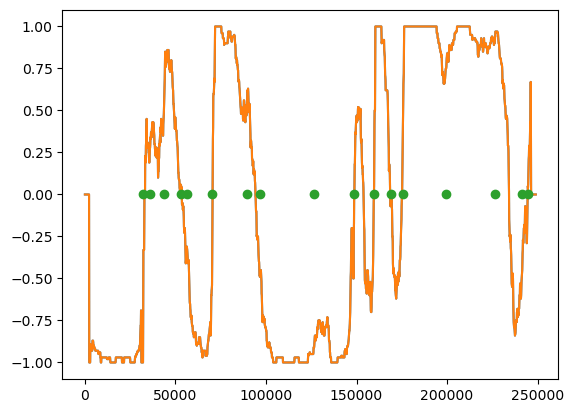

In [18]:
from fast_rep.interface import compute_mrt_and_derivatives_pos
v=1000
model="Weibull"
f,axes = subplots(1,1)
#m_kis =  np.exp(np.array(r["params"]["kis"])) #mean(r["draws"]["kis"],axis=0)
#m_kis = np.mean(r["other"]["draws"]["kis"],axis=0)
m_kis = r0["params"]["kis"]
#k.shape
#errorbar(np.arange(n_ori),np.mean(k,axis=0),np.std(k,axis=0))
if "kis_std" in r0["params"]:
    
    m_kis_std =  np.std(r0["other"]["draws"]["kis"],axis=0)
else:
    m_kis_std = np.zeros_like(m_kis)

m_extra_t = np.array([0] * n_ori)#
m_extra_t = r0["params"]["extra_t"]
#m_extra_t = np.array([0] * n_ori)#

if "extra_t_std" in r0["params"]:
    m_extra_t_std = r0["params"]["extra_t_std"]
else:
    m_extra_t_std = np.zeros_like(m_kis)


#m_qis = np.ones_like(m_qis)
mrtr,rfd_simu = compute_mrt_and_derivatives_pos(pos,m_kis, m_extra_t, xis, v=fork_speed, model=model,method='central', shift=1,resolution=100)
plot(pos,rfd)
plot(pos,rfd)
plot(xis,np.zeros_like(xis),"o")

In [27]:
from fast_rep.rfd_tools import extract_most_potent_ori_around_expected_value
from fast_rep.bayesian_optim import estimate_n_ori
from time import time
t0=time()
pos = np.arange(len(rfd))*resolution

delta=15
S = 20.
expected_distance = 30_000
noise=0.075
mode="Laplace"

prior_on_lamba=S/2
prior_on_extra_t=S/4
expected_n_ori = int(len(rfd) * resolution /  expected_distance)
GT = rfd_simu + (1-2*np.random.rand(len(rfd)))*noise


xis,delta_v,vals=find_ori_position(data={"rfd":GT,"positions":pos},min_dist_ori=min_dist_ori,
                                                smoothv=11,
                                                min_rfd_increase_by_kb=0) 


ps,data = convert_RFD_delta_MRT(pos,GT,speed=fork_speed,resolution=resolution,delta=delta,measurement_type=measurement_type)
Ori_pos = extract_most_potent_ori_around_expected_value(xis,vals["prominences"],expected_n_ori,
                                                      max_factor_expected=2.5,
                                                      min_factor_expected=0.7)
std_data = np.zeros_like(data)+noise/delta**0.5



verbose=False





results = {}
for model in ["Weibull","Exponential"]:
    results[model] = {}

    for delay in ["delay","without delay"]:
        if delay == "without delay":
            prior_on_extra_t0=None
        else:
            prior_on_extra_t0 = prior_on_extra_t
        results[model][delay] = estimate_n_ori(Ori_pos,model,ps,data,std_data,prior_on_lamba,prior_on_extra_t0,S,fork_speed,measurement_type=measurement_type,mode=mode)

    #results[model]["without delay"] = estimate_n_ori(Ori_pos,model,ps,data,std_data,prior_on_lamba,None,S,fork_speed,measurement_type=measurement_type)

print(time()-t0)

20 5
[array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,  36000, 198900, 226500,  25600, 105800,  14300, 207900,
        66000, 118900,   3300]), array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,  36000, 198900, 226500,  25600, 105800,  14300, 207900,
        66000, 118900]), array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,  36000, 198900, 226500,  25600, 105800,  14300, 207900,
        66000]), array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,  36000, 198900, 226500,  25600, 105800,  14300, 207900]), array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,  36000, 198900, 226500,  25600, 105800,  14300]), array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,  36000, 198900, 226500,  25600, 105800]), array([159400, 175800,  70700, 148900, 245200,  31900,  43900, 126300,
       168500,

In [26]:
results["Weibull"].keys()

dict_keys(['without delay'])

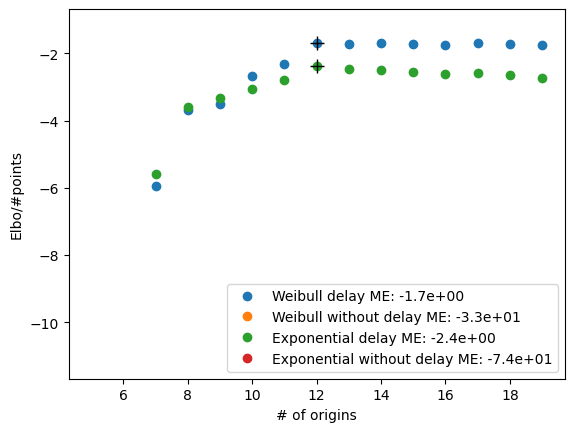

In [28]:
maxis = []
for model in ["Weibull","Exponential"]:
    for delay in ["delay","without delay"]:
        
        r = results[model][delay]
        number_of_points_fitted = len(r["detail_results"][0]["theo"])
        elbo = np.array(r["elbo"]) /  number_of_points_fitted
        m = np.argmax(elbo)
        M = np.max(elbo)
        maxis.append(M)
        plot(r["number_of_origins"],elbo,"o",label=f"{model} {delay} ME: {M:.1e}")
        plot(r["number_of_origins"][m],elbo[m],"+k",markersize=10)
        xlabel("# of origins")
        ylabel("Elbo/#points")

        #ylim(-20000,None)#,-11400)

ylim(max(maxis)-10,max(maxis)+1)
legend()

12


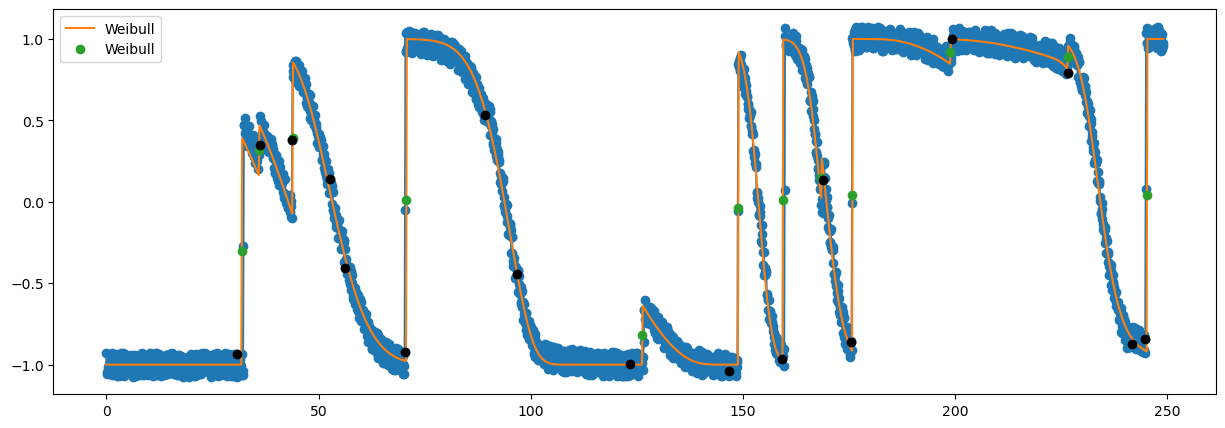

In [29]:


pos = np.arange(len(GT)) *resolution
f=figure(figsize=(15,5))
f.add_subplot(111)
plot(pos/1000,GT,"-o")


for model in ["Weibull","Exponential"][:1]:
    delay="delay"
  
    
    r = results[model][delay]
    m = np.argmax(r["elbo"])
    params = r["detail_results"][m]["params"]
    xis = r["origin_positionning"][m]
    print(len(xis))

    
    if delay == "without delay":
        extra_t = np.zeros_like(params["kis"])
    else:
        extra_t = params["extra_t"]
    mrtr,rfd0 = compute_mrt_and_derivatives_pos(pos,params["kis"], extra_t, xis, v=fork_speed, model=model,method='central', shift=1,resolution=100)
    plot(pos/1000,rfd0,label=model)
    plot(xis/1000,rfd0[xis//100],"o",label=model)

    legend()
    #xlim(20,60)
    

ip=1
#plot(Ori_pos[ip]/1000,np.zeros_like(Ori_pos[ip]),"o")

#amplitude = delta_v[xis]
#figure()
plot(xis0 /1000,GT[xis0//100],"o",color="k")
#plot(pos/1000,delta_v-smooth(delta,51),"o")

#xlim(20,60)


# fit with the origins correctly located 

In [32]:
n_ori = len(xis0)
fit_time=True

prior_on_lamba=S/2
prior_on_extra_t=S/4
expected_n_ori = int(len(rfd) * resolution /  expected_distance)
GT = rfd + (1-2*np.random.rand(len(rfd)))*noise


xis,delta_v,vals=find_ori_position(data={"rfd":GT,"positions":pos},min_dist_ori=min_dist_ori,
                                                smoothv=19,
                                                min_rfd_increase_by_kb=0) 


ps,data = convert_RFD_delta_MRT(pos,GT,speed=fork_speed,resolution=resolution,delta=delta,measurement_type=measurement_type)
Ori_pos = extract_most_potent_ori_around_expected_value(xis,vals["prominences"],expected_n_ori,
                                                      max_factor_expected=2.5,
                                                      min_factor_expected=0.7)
std_data = np.zeros_like(data)+noise/delta**0.5



initial_lambda = jnp.array([1/(prior_on_lamba)] * n_ori)
if fit_time:
    init_extra_t = jnp.array([1/prior_on_extra_t]  * n_ori)
else:
    init_extra_t = None
#print(len(xis),len(init_extra_t),len(initial_lambda))
r = fit_at_pos_using_map_as_starting_point(pos_to_compute=ps,xis=xis0,prior_on_lambda=initial_lambda,prior_on_extra_t=init_extra_t,
  prior_on_qis=init_qis,fork_speed=fork_speed,
  data=data,S_phase_duration=S,sigma=std_data,measurement_type=measurement_type,model=model,only_optim=False)


20 5
use_qi False
use_extrat True


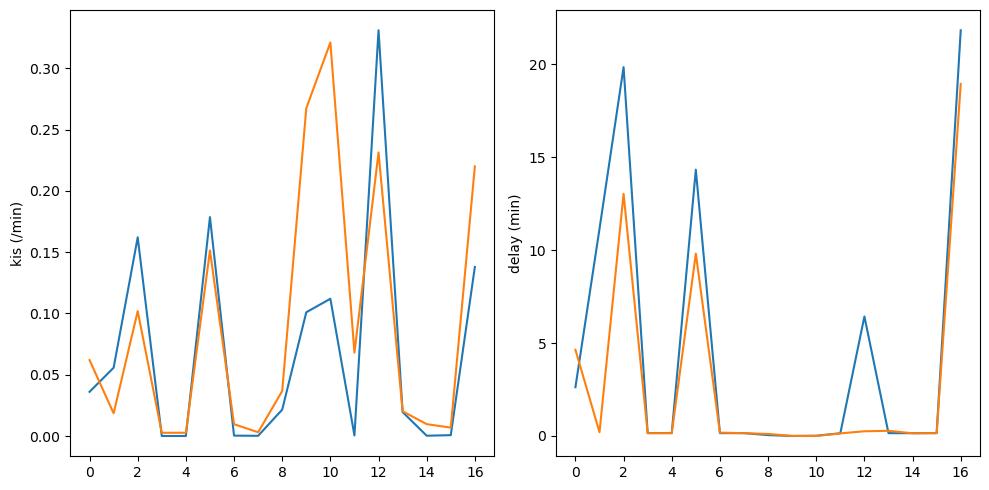

In [33]:
f,axes = subplots(1,2,figsize=(10,5))
model="Weibull"
#r=results[model]["delay"]
#m = np.argmax(r["elbo"])
params = r["params"]#["detail_results"][m]["params"]
ori = range(len(params["kis"]))
axes[0].errorbar(x=ori,y=params["kis"],yerr=params["kis_std"])
paramso=r0["params"]
ori = range(len(paramso["kis"]))
axes[0].errorbar(x=ori,y=paramso["kis"],yerr=paramso["kis_std"])
axes[0].set_ylabel("kis (/min)")
if "extra_t" in params:
    axes[1].errorbar(x=ori,y=params["extra_t"],yerr=params["extra_t_std"])
    axes[1].errorbar(x=ori,y=paramso["extra_t"],yerr=paramso["extra_t_std"])
    axes[1].set_ylabel("delay (min)")
f.tight_layout()